<a href="https://colab.research.google.com/github/rahul0425/Motion-Planning--RRT-star/blob/main/Motion_Planning_RRT_star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from random import random
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from collections import deque

In [ ]:
class Line():
  def __init__(self,p0,p1):
    self.p= np.array(p0)
    self.dirn= np.array(p1)-np.array(p0)
    self.dist=np.linalg.norm(self.dirn)
    self.dirn/= self.dist

  def path(self,t):
    return self.p + t * selfdirn

def intersection(line,center,radius):

  a=np.dot(line.dirn,line.dirn)
  b=2*np.dot(line.dirn,line.p-center)
  c=np.dot(line.p-center,line.p-center)- radius*radius

  d=b*b -4*a*c
  if d<0:
    return False
  
  return True


In [ ]:
def distance(x,y):
  return np.linalg.norm(np.array(x)-np.array(y))

In [ ]:
def isinobstacle(vex,obstacle,radius):
  for obs in obstacle:
    if distance(obs,vex)<radius:
      return True
  return False

In [ ]:
def isthruobstacle(line,obstacle,radius):
  for obs in obstacle:
    if intersection(line,obs,radius):
      return True
  return False

In [ ]:
def nearest(G,vex,obstacle,radius):
  nvex=None
  nidx=None
  min_dist= float('inf')

  for idx,v in enumerate(G.vertices):
    line=Line(v,vex)
    if isthruobstacle(line,obstacle,radius):
      continue
    dist=distance(v,vex)
    if dist<min_dist:
      min_dist = dist
      nidx=idx
      nvex=v
  
  return nvex,nidx

In [ ]:
def newvertex(randvex, nearvex,stepsize):
  dirn= np.array(randvex) - np.array(nearvex)
  length= np.linalg.norm(dirn)
  dirn= (dirn/length) *min(stepsize,length)

  newvex=(nearvex[0]+dirn[0],nearvex[1]+dirn[1])
  return newvex

In [ ]:
def window(start,end):
  width= end[0]-start[0]
  height= end[1]-start[1]
  winx=start[0] - (width/2.)
  winy=start[1]- (height/2.)

  return winx,winy.width,height

  

In [ ]:
def isinwindow(pos,winx,winy,width,height):
  if winx< pos[0]<winx+width and winy<pos[1]< winy+height:
    return True
  else:
    return False
    

In [ ]:
class Graph:
  def __init__(self,start,end):
    self.start=start
    self.end=end

    self.vertices=[start]
    self.edges=[]
    self.success=False

    self.vex2idx = {start:0}
    self.neighbors={0:[]}
    self.distances={0:0.}
    
    self.sx=end[0] -start[0]
    self.sy=end[1]-start[1]

  def add_vex(self,pos):
    try:
      idx=self.vex2idx[pos]
    except:
      idx=len(self.vertices)
      self.vertices.append(pos)
      self.vex2idx[pos]=idx
      self.neighbors[idx]=[]
    return idx

  def add_edge(self,idx1,idx2,cost):
    self.edges.append((idx1,idx2))
    self.neighbors[idx1].append((idx2,cost))
    self.neighbors[idx2].append((idx1,cost))

  def randomposition(self):
    rx=random()
    ry=random()

    posx= self.start[0] - (self.sx/2.) + rx*self.sx*2
    posy= self.start[0] - (self.sy/2.) + ry*self.sy*2

    return posx,posy



In [ ]:
def RRT_star(start,end,obstacle,iter,radius,stepSize):
  G= Graph(start,end)
  for _ in range(iter):
    randvex= G.randomposition()
    if isinobstacle(randvex,obstacle,radius):
      continue

    nearvex,nearidx=nearest(G,randvex,obstacle,radius)
    if nearvex is None:
      continue
    
    newvex= newvertex(randvex, nearvex,stepsize)

    newidx= G.add_vex(newvex)
    dist=distance(newvex,nearvex)
    G.add_edge(newidx, nearidx, dist)
    G.distances[newidx]= G.distances[nearidx]+dist

    for vex in G.vertices:
      if vex==newvex:
        continue
      
      dist= distance(vex,newvex)
      if dist > radius:
        continue

      line=Line(vex,newvex)
      if isthruobstacle(line,obstacle,radius):
        continue

      idx = G.vex2idx[vex]
      if G.distances[newidx] +dist < G.distances[idx]:
        G.add_edge(idx,newidx,dist)
        G.distances[idx] = G.distances[newidx]+ dist

      dist= distance(newvex,G.end)
      if dist<2 *radius:
        endidx=G.add_vex(G.end)
        G.add_edge(newidx,endidx,dist)
        try:
          G.distances[endidx]+ min(G.distances[endidx],G.distances[newidx]+dist)
        except:
          G.distances[endidx]= G.distances[newidx]+dist

        G.success= True
  return G

In [ ]:
def dijkstra(G):

  srcidx= G.vex2idx[G.start]
  dstidx= G.vex2idx[G.end]

  nodes = list(G.neighbors.keys())
  dist={node:float('inf') for node in nodes}
  prev= {node: None for node in nodes}
  dist[srcidx]=0

  while nodes:
    curNode= min(nodes, key=lambda node:dist[node])
    nodes.remove(curNode)
    if dist[curNode]== float('inf'):
      break

    for neighbor, cost in G.neighbors[curNode]:
      newCost= dist[curNode]+cost
      if newCost < dist[neighbor]:
        dist[neighbor]= newCost
        prev[neighbor]=curNode

  path =deque()
  curNode=dstidx

  while prev[curNode] is not None:
    path.appendleft(G.vertices[curNode])
    curNode=prev[curNode]
  path.appendleft(G.vertices[curNode])
  return list(path)

In [ ]:
def plot(G, obstacle,radius,path=None):

  px=[x for x,y in G.vertices]
  py= [y for x,y in G.vertices]
  fig, ax= plt.subplots()

  for obs in obstacle:
    circle= plt.Circle(obs,radius, color='red')
    ax.add_artist(circle)

  ax.scatter(px,py,c='cyan')
  ax.scatter(G.start[0],G.start[1], c='black')
  ax.scatter(G.end[0],G.end[1],c='black')

  lines=[(G.vertices[edge[0]],G.vertices[edge[1]]) for edge in G.edges]
  lc= mc.LineCollection(lines,colors='green', linewidths=2)
  ax.add_collection(lc)

  if path is not None:
    paths=[(path[i],path[i+1]) for i in range(len(path)-1)]
    lc2=mc.LineCollection(paths,colors='blue',linewidths=3)
    ax.add_collection(lc2)

  ax.autoscale()
  ax.margins(0.1)
  plt.show()



In [ ]:
def pathsearch(start,end,obstacle,iter,radius,stepsize):
  G= RRT_star(start,end,obstacle,iter,radius,stepsize)
  if G.success:
    path=dijkstra(G)

    return path

[(0.0, 0.0), (-0.011645219791372658, 0.6999031281941884), (-0.06854619712195054, 1.397586637228783), (-0.3587754288598811, 2.03458506190879), (-0.43872018132906043, 2.7300049613599358), (-0.1966280278407474, 3.386808881277738), (0.4240420442443861, 3.710488756490633), (0.8674710722522796, 4.252125809432891), (1.5661212058455702, 4.2086747929882), (2.090050073472729, 4.672892997787326), (2.7254135035243228, 4.966684270212279), (3.4225605497390554, 4.903549525783609), (4.11852209561513, 4.978632990419868), (4.66057550033259, 5.421552967881045), (4.960559062602407, 6.054016296753092), (5.6601327702959345, 6.078442256384812), (5.453362417184574, 6.403153043127089), (5.0, 6.0)]


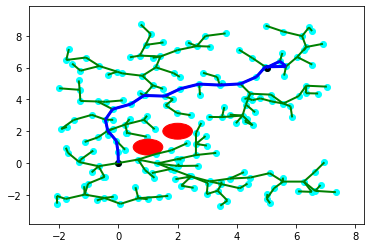

In [ ]:
if __name__=='__main__':
  start=(0.,0.)
  end=(5.,6.)
  obstacle=[(1.,1.),(2.,2.)]
  iter=200
  radius=0.5

  stepsize=0.7

  G= RRT_star(start,end,obstacle,iter,radius,stepsize)

  if G.success:
    path= dijkstra(G)
    print(path)
    plot(G,obstacle,radius,path)

  else:
    plot(G,obstacle,radius)